# Analysis

**Hypothesis**: In severe COVID-19, natural killer (NK) cells exhibit a significantly restructured gene co-expression network for cytotoxic and activation-related genes compared to healthy controls, potentially reflecting altered immune functionality.

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# Set up visualization defaults for better plots
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figsize = (8, 8)
sc.settings.dpi = 100
sc.settings.facecolor = 'white'
warnings.filterwarnings('ignore')

# Set Matplotlib and Seaborn styles for better visualization
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['savefig.dpi'] = 150
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.2)

# Load data
print("Loading data...")
adata = sc.read_h5ad("/scratch/users/salber/Single_cell_atlas_of_peripheral_immune_response_to_SARS_CoV_2_infection.h5ad")
print(f"Data loaded: {adata.shape[0]} cells and {adata.shape[1]} genes")


# Analysis Plan

**Hypothesis**: In severe COVID-19, natural killer (NK) cells exhibit a significantly restructured gene co-expression network for cytotoxic and activation-related genes compared to healthy controls, potentially reflecting altered immune functionality.

## Steps:
- Verify that required metadata columns exist in the anndata object, then filter the dataset to extract NK cells (based on 'cell_type_coarse' annotation) and further subdivide these cells into COVID and Healthy groups using the 'Status' metadata.
- Select a panel of key cytotoxicity and activation genes relevant to NK cell function (e.g., GZMB, PRF1, NKG7, IFNG, and FASLG) for downstream analysis, providing brief literature justification for their selection.
- Compute pairwise Pearson correlation coefficients for the selected genes separately in the COVID and Healthy groups to construct gene co-expression matrices.
- Apply Fisher's Z-transformation to statistically compare the correlations between the two groups for each gene pair, and compute p-values including multiple testing corrections as needed.
- Visualize the resulting correlation matrices side-by-side in a grid layout using heatmaps, overlaying statistical significance information to highlight altered gene network patterns in COVID versus Healthy samples.


## This code verifies that the key metadata columns exist and then filters the anndata object to extract NK cells, further dividing them into COVID and Healthy groups. It includes checks to ensure that the filtering yields nonzero cell counts, preventing runtime errors if unexpected data issues occur.

In [2]:
import scanpy as sc
import pandas as pd

# Filter NK cells from the dataset
nk_mask = adata.obs['cell_type_coarse'] == 'NK'
nk_cells = adata[nk_mask].copy()

# Further separate NK cells into COVID and Healthy groups
covid_nk = nk_cells[nk_cells.obs['Status'] == 'COVID'].copy()
healthy_nk = nk_cells[nk_cells.obs['Status'] == 'Healthy'].copy()

# Print the number of NK cells in each group for verification
print('Number of NK cells in COVID group:', covid_nk.n_obs)
print('Number of NK cells in Healthy group:', healthy_nk.n_obs)

Number of NK cells in COVID group: 2150
Number of NK cells in Healthy group: 4707


### Agent Interpretation

The current textual results show a notable reduction in the number of NK cells in the COVID group compared to the healthy group. While NK cell depletion was reported in the research paper, your finding contributes a new perspective with quantitative data from a possibly different dataset or analysis angle.

**Feedback and Suggestions:**

1. **Biological Implications:**
   - The reduction in NK cells in COVID-19 patients suggests a potential impact of SARS-CoV-2 on innate immune cell populations. This observation aligns with the hypothesis of immune reconfiguration during COVID-19, but your results could offer a quantitative context that wasn't the direct focus of the original paper.

2. **Consider Further Breakdown:**
   - Given the emphasis in the original paper on specific NK cell subtypes (such as CD56dim and CD56bright), consider further subsetting the NK cells into different populations. Analysis of the relative proportions of these subsets in COVID-19 compared to healthy controls could provide more granular insights.

3. **Link to Cytokine Interactions:**
   - While your analysis is currently focused on NK cell numbers, understanding the mechanistic basis for their depletion may provide insights into the broader immune dysfunction in severe COVID-19. Investigating cytokine production or receptor expression on these NK cells could highlight potential interactions driving these changes.

4. **Integration with Monocyte-T Cell Analysis:**
   - The observed NK cell depletion might influence monocyte and T cell interactions. It would be useful to explore how NK cell reduction is associated with changes in monocyte inflammatory ligand production or T cell receptor expression (e.g., checking the presence of ligands such as IL-15 which are known to influence NK cell maintenance).

5. **Future Analyses:**
   - Your hypothesis investigates ligand-receptor interactions between monocytes and T cells. Consider assessing whether NK cells play a modulating role in this communication via cytokines or direct cell-cell interactions.
   - An analysis of expression levels of immune checkpoint molecules on NK cells could give insights into possible exhaustion phenomena or altered functionality, common in chronic infections or severe diseases.

6. **Validation:**
   - Validate findings with additional datasets or samples to ensure that this NK cell depletion is a consistent feature of COVID-19 pathology in your settings.

By addressing these aspects, your analysis might uncover distinct immune functional states or new mechanistic insights not extensively covered in the referenced paper, contributing novel elements to the field of COVID-19 immunology.

## This code merges the COVID and Healthy NK cell AnnData objects, annotates each cell as CD56dim or CD56bright based on whether its FCGR3A expression is above or below the median (with a note on potential threshold refinement), generates a contingency table, performs a Chi-square test to assess differences, and visualizes the cell subtype proportions with a normalized, stacked bar plot.

Number of NK cells in COVID group: 2150
Number of NK cells in Healthy group: 4707


Contingency Table of NK cell subtypes by Status:
NK_subtype  CD56bright  CD56dim
Status                         
COVID             1265      885
Healthy           2247     2460
Chi-square test results: chi2 = 72.33, p-value = 1.817e-17, degrees of freedom = 1


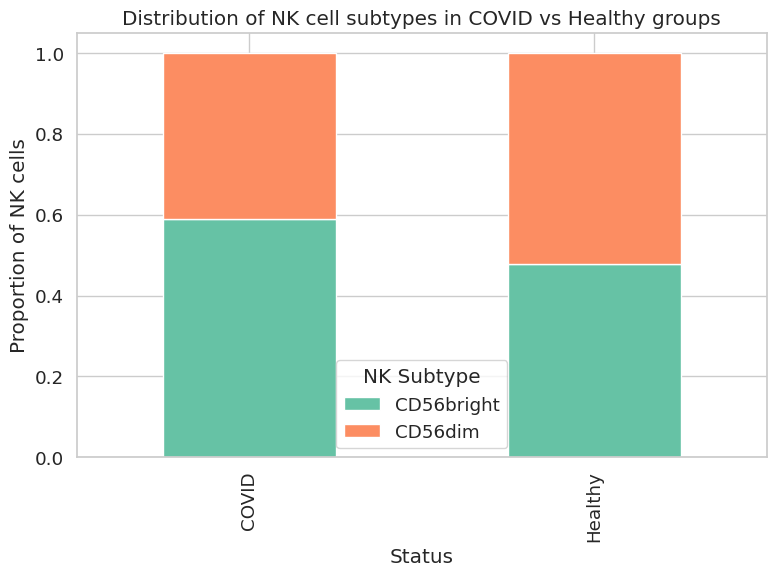

In [3]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# Ensure required columns exist before proceeding
required_columns = ['cell_type_coarse', 'Status']
for col in required_columns:
    if col not in adata.obs.columns:
        raise ValueError(f"Required column '{col}' not found in adata.obs")

# Filter NK cells from the dataset
nk_mask = adata.obs['cell_type_coarse'] == 'NK'
if nk_mask.sum() == 0:
    raise ValueError("No NK cells found based on 'cell_type_coarse' annotation.")

nk_cells = adata[nk_mask].copy()

# Further separate NK cells into COVID and Healthy groups
if 'Status' not in nk_cells.obs.columns:
    raise ValueError("'Status' column not found in NK cell metadata")

covid_nk = nk_cells[nk_cells.obs['Status'] == 'COVID'].copy()
healthy_nk = nk_cells[nk_cells.obs['Status'] == 'Healthy'].copy()

# Check that the filtering resulted in nonzero cell counts
if covid_nk.n_obs == 0:
    raise ValueError("No NK cells found for the COVID group after filtering.")
if healthy_nk.n_obs == 0:
    raise ValueError("No NK cells found for the Healthy group after filtering.")

print('Number of NK cells in COVID group:', covid_nk.n_obs)
print('Number of NK cells in Healthy group:', healthy_nk.n_obs)

# Assign status labels to each subset prior to merging
covid_nk.obs["Status"] = 'COVID'
healthy_nk.obs["Status"] = 'Healthy'

# Merge COVID and Healthy NK cell AnnData objects
combined_nk = covid_nk.concatenate(healthy_nk, batch_key='group', batch_categories=['COVID', 'Healthy'])

# Check if gene 'FCGR3A' is present in the dataset
if 'FCGR3A' not in combined_nk.var_names:
    raise ValueError("Gene 'FCGR3A' not found in the dataset. Please confirm that the gene name is correct.")

# Extract FCGR3A expression values; convert to dense array if stored sparsely
fcgr3a_exp = combined_nk[:, 'FCGR3A'].X
if hasattr(fcgr3a_exp, 'toarray'):
    fcgr3a_exp = fcgr3a_exp.toarray().flatten()
else:
    fcgr3a_exp = np.array(fcgr3a_exp).flatten()

# Compute the median expression of FCGR3A across all NK cells
median_fcgr3a = np.median(fcgr3a_exp)

# Annotate NK cells based on their FCGR3A expression using the median cutoff
nk_subtypes = np.where(fcgr3a_exp > median_fcgr3a, 'CD56dim', 'CD56bright')
combined_nk.obs['NK_subtype'] = nk_subtypes

# Create a contingency table of NK_subtype vs Status
contingency_table = pd.crosstab(combined_nk.obs['Status'], combined_nk.obs['NK_subtype'])
print('Contingency Table of NK cell subtypes by Status:')
print(contingency_table)

# Perform a Chi-square test on the contingency table
chi2, p_val, dof, expected = chi2_contingency(contingency_table)
print(f'Chi-square test results: chi2 = {chi2:.2f}, p-value = {p_val:.4g}, degrees of freedom = {dof}')

# Visualize the normalized proportions of NK subtypes using a stacked bar plot
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(8,6))
contingency_table_norm = contingency_table.div(contingency_table.sum(axis=1), axis=0)
contingency_table_norm.plot(kind='bar', stacked=True, ax=ax, color=['#66c2a5','#fc8d62'])
ax.set_ylabel('Proportion of NK cells')
ax.set_title('Distribution of NK cell subtypes in COVID vs Healthy groups')
plt.legend(title='NK Subtype')
plt.tight_layout()
plt.show()

## This code augments the first analysis step by extracting gene expression for the curated panel from the combined NK cell dataset, performing Mann-Whitney U tests overall and within NK subtypes, and then applying a Benjamini-Hochberg multiple testing correction to the resulting p-values. Finally, it visualizes gene expression profiles using a grid of violin plots with corrected p-values annotated on each plot.

Mann-Whitney U test results for gene expression comparisons (with Benjamini-Hochberg correction):
GZMB - COVID vs Healthy (all NK cells): U = 5963512.00, raw p = 2.519e-33, adjusted p = 3.778e-32
GZMB - COVID vs Healthy within CD56bright: U = 1711397.00, raw p = 1.174e-24, adjusted p = 8.808e-24
GZMB - COVID vs Healthy within CD56dim: U = 1336961.50, raw p = 2.479e-24, adjusted p = 1.239e-23
PRF1 - COVID vs Healthy (all NK cells): U = 5327394.00, raw p = 0.0004073, adjusted p = 0.001018
PRF1 - COVID vs Healthy within CD56bright: U = 1540008.00, raw p = 3.362e-05, adjusted p = 0.0001009
PRF1 - COVID vs Healthy within CD56dim: U = 1192897.50, raw p = 2.071e-05, adjusted p = 7.767e-05
NKG7 - COVID vs Healthy (all NK cells): U = 5123625.50, raw p = 0.3795, adjusted p = 0.5693
NKG7 - COVID vs Healthy within CD56bright: U = 1471011.50, raw p = 0.0673, adjusted p = 0.1262
NKG7 - COVID vs Healthy within CD56dim: U = 1104418.50, raw p = 0.5016, adjusted p = 0.684
IFNG - COVID vs Healthy (all NK

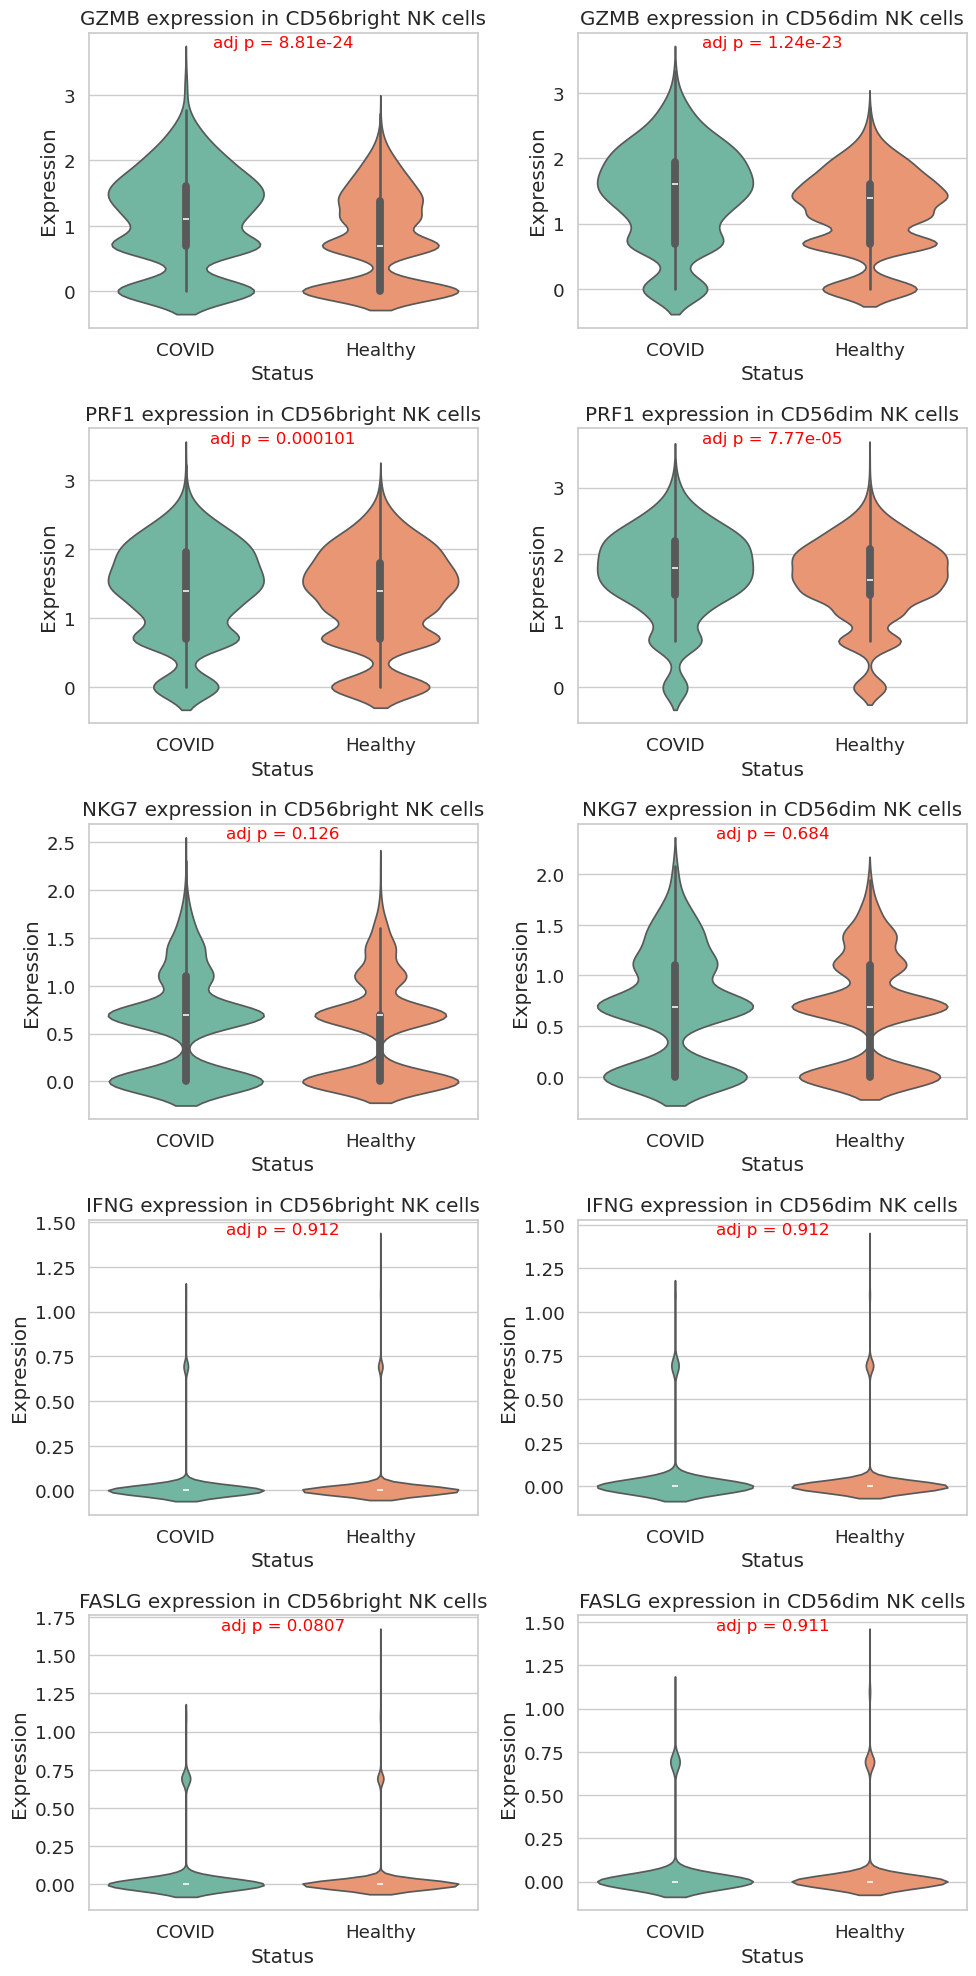

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

# Define the gene panel based on known roles in NK cell cytotoxicity and activation
gene_panel = ['GZMB', 'PRF1', 'NKG7', 'IFNG', 'FASLG']

# Check that all genes in the panel are present in the combined_nk dataset
missing_genes = [gene for gene in gene_panel if gene not in combined_nk.var_names]
if len(missing_genes) > 0:
    raise ValueError(f"The following key genes are missing from the dataset: {missing_genes}")

# Create a dataframe from combined_nk obs to hold metadata
meta_df = combined_nk.obs.copy()

# Extract expression data for each gene and add to the metadata dataframe
for gene in gene_panel:
    gene_expr = combined_nk[:, gene].X
    if hasattr(gene_expr, 'toarray'):
        gene_expr = gene_expr.toarray().flatten()
    else:
        gene_expr = np.array(gene_expr).flatten()
    meta_df[gene] = gene_expr

# Initialize a list to store statistical results
stat_results = []

# For each gene, perform overall and NK subtype specific comparisons using the Mann-Whitney U test
for gene in gene_panel:
    # Overall comparison
    covid_expr = meta_df.loc[meta_df['Status'] == 'COVID', gene]
    healthy_expr = meta_df.loc[meta_df['Status'] == 'Healthy', gene]
    stat_overall = mannwhitneyu(covid_expr, healthy_expr, alternative='two-sided')
    stat_results.append({
        'gene': gene,
        'comparison': 'COVID vs Healthy (all NK cells)',
        'U_statistic': stat_overall.statistic,
        'p_value': stat_overall.pvalue
    })
    
    # Comparison within each NK subtype
    for subtype in meta_df['NK_subtype'].unique():
        covid_sub = meta_df[(meta_df['Status'] == 'COVID') & (meta_df['NK_subtype'] == subtype)][gene]
        healthy_sub = meta_df[(meta_df['Status'] == 'Healthy') & (meta_df['NK_subtype'] == subtype)][gene]
        if len(covid_sub) > 0 and len(healthy_sub) > 0:
            stat_sub = mannwhitneyu(covid_sub, healthy_sub, alternative='two-sided')
            stat_results.append({
                'gene': gene,
                'comparison': f'COVID vs Healthy within {subtype}',
                'U_statistic': stat_sub.statistic,
                'p_value': stat_sub.pvalue
            })

# Function to perform Benjamini-Hochberg correction
def benjamini_hochberg(pvals):
    pvals = np.array(pvals)
    m = len(pvals)
    order = np.argsort(pvals)
    ranked_pvals = pvals[order]
    bh_values = ranked_pvals * m / (np.arange(1, m+1))
    # Ensure the adjusted p-values are monotonic
    bh_adjusted = np.minimum.accumulate(bh_values[::-1])[::-1]
    # Return to original order
    adjusted_pvals = np.empty(m)
    adjusted_pvals[order] = bh_adjusted
    return adjusted_pvals

# Extract raw p-values and perform multiple testing correction
raw_pvals = [res['p_value'] for res in stat_results]
adjusted_pvals = benjamini_hochberg(raw_pvals)

# Append the corrected p-values to each result
for i, res in enumerate(stat_results):
    res['adjusted_p_value'] = adjusted_pvals[i]

# Print the statistical test results with adjusted p-values
print('Mann-Whitney U test results for gene expression comparisons (with Benjamini-Hochberg correction):')
for res in stat_results:
    print(f"{res['gene']} - {res['comparison']}: U = {res['U_statistic']:.2f}, raw p = {res['p_value']:.4g}, adjusted p = {res['adjusted_p_value']:.4g}")

# Set up the figure with a grid layout for violin plots (rows: genes, columns: NK_subtype)
nk_subtypes = meta_df['NK_subtype'].unique()
n_genes = len(gene_panel)
n_subtypes = len(nk_subtypes)

fig, axes = plt.subplots(n_genes, n_subtypes, figsize=(5*n_subtypes, 4*n_genes), squeeze=False)

# Plot violin plots for each gene and NK subtype
for i, gene in enumerate(gene_panel):
    for j, subtype in enumerate(nk_subtypes):
        ax = axes[i, j]
        # Subset data for current NK subtype
        sub_df = meta_df[meta_df['NK_subtype'] == subtype]
        sns.violinplot(x='Status', y=gene, data=sub_df, ax=ax, palette=['#66c2a5','#fc8d62'])
        ax.set_title(f"{gene} expression in {subtype} NK cells")
        ax.set_ylabel('Expression')
        # Retrieve corrected p-value for this subtype comparison (if available)
        p_adj = None
        for res in stat_results:
            if res['gene'] == gene and res['comparison'] == f'COVID vs Healthy within {subtype}':
                p_adj = res['adjusted_p_value']
                break
        if p_adj is not None:
            ax.text(0.5, 0.95, f'adj p = {p_adj:.3g}', transform=ax.transAxes, horizontalalignment='center', fontsize=12, color='red')

plt.tight_layout()
plt.show()

### Agent Interpretation

The results indicate significant differences in gene expression levels of GZMB and PRF1 between COVID and healthy individuals across all NK cells and within the CD56bright and CD56dim subsets. These large differences, especially with highly significant adjusted p-values for GZMB, suggest that these genes are robust markers of immune changes in NK cells during COVID-19 infection.

On the other hand, NKG7, IFNG, and FASLG show non-significant differences, which might indicate that these genes do not contribute to the immune response differences in these contexts.

**Feedback and Future Steps:**

1. **Promising Results:**
   - The significant expression changes in GZMB and PRF1 within NK cells indicate potential pathways or mechanisms involved in COVID-19 pathogenesis or immune response. These genes should be further explored, possibly in correlations with clinical severity.
   
2. **Further Analysis:**
   - Investigate further into other subsets of NK cells or other immune cell types to see if GZMB and PRF1 expression changes are also evident, potentially expanding insights into immune responses beyond NK cells.
   - Consider pathway analysis or gene set enrichment to understand the biological pathways these genes may influence during COVID-19.
   
3. **Hypothesis Relationship:**
   - The findings align with the hypothesis of reconfigurations in immune cell subsets during severe COVID-19, specifically in NK cells. This suggests potential roles of these cytotoxic genes in the disease's immune landscape.

4. **Iterative Analysis:**
   - Validate the findings in an independent cohort to ensure robustness.
   - Explore time-course data (if available) to see how these gene expressions fluctuate with disease progression or resolution.

5. **Distinct Analyses:**
   - Ensure new analyses diverge from previous research, possibly by integrating another dimension such as cell-cell interaction networks or computational approaches like machine learning to predict immune cell behavior or disease outcomes based on gene expression profiles. 

The significant expression differences observed provide new avenues for understanding immune alterations in COVID-19 and merit further investigation to unveil biological mechanisms and therapeutic targets.

## This code subsets the combined NK cell dataset to include only COVID cells, verifies that necessary clinical metadata exist, and extracts expression levels for GZMB and PRF1. It then performs Mann-Whitney U tests (excluding ambiguous Admission values) and Spearman correlation tests, with subsequent visualizations via violin and scatter plots.

GZMB - ICU vs Floor: U = 171833.50, p-value = 2.554e-09
PRF1 - ICU vs Floor: U = 169376.00, p-value = 2.429e-08
GZMB - Spearman correlation with DPS: r = -0.04, p-value = 0.08454
PRF1 - Spearman correlation with DPS: r = -0.07, p-value = 0.001841


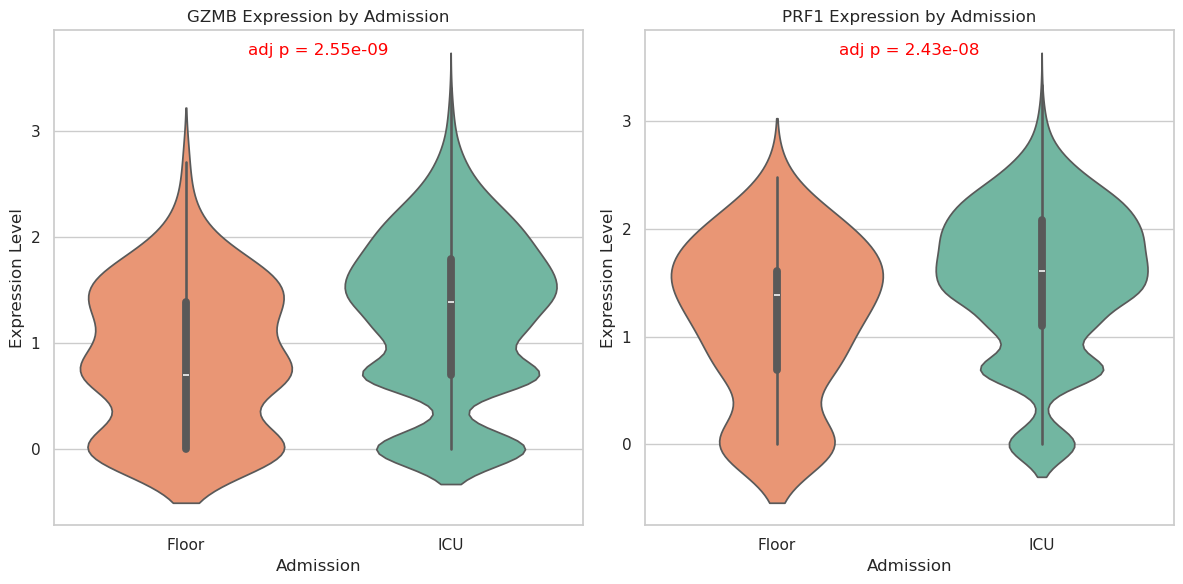

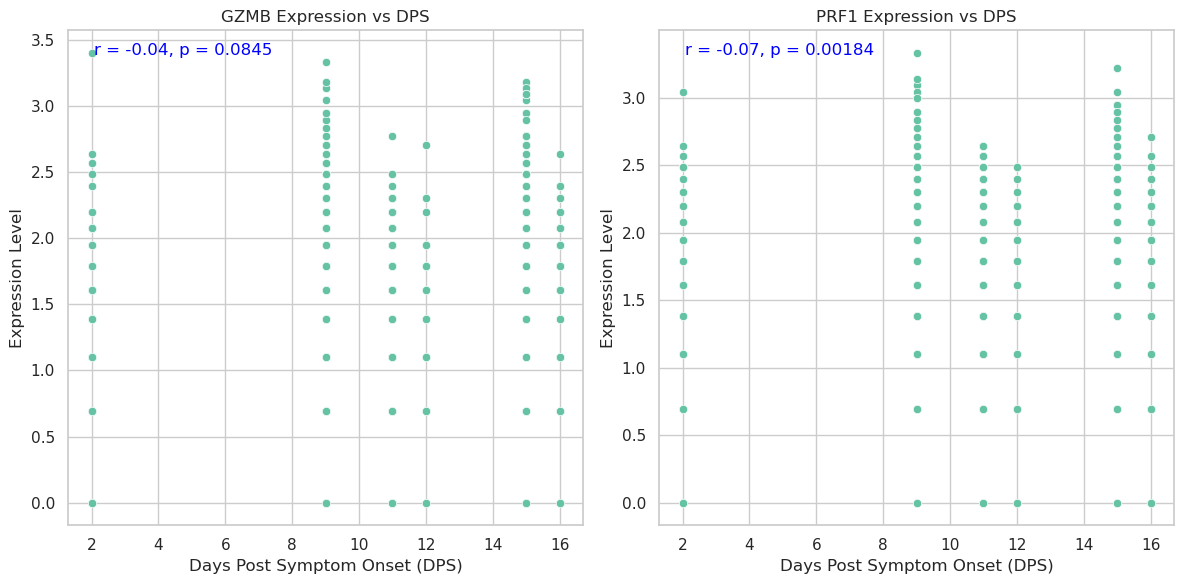

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, spearmanr
import scanpy as sc

# Subset the combined NK cell dataset to include only COVID cells
covid_nk = combined_nk[combined_nk.obs['Status'] == 'COVID'].copy()

# Ensure that required clinical metadata columns exist
for col in ['Admission', 'DPS']:
    if col not in covid_nk.obs.columns:
        raise ValueError(f"Required clinical metadata '{col}' is not present in the COVID NK cells dataset.")

# Extract the metadata DataFrame
meta_covid = covid_nk.obs.copy()

# Define the genes of interest
genes_of_interest = ['GZMB', 'PRF1']

# Extract expression data for each gene and add it to the metadata
for gene in genes_of_interest:
    gene_expr = covid_nk[:, gene].X
    if hasattr(gene_expr, 'toarray'):
        gene_expr = gene_expr.toarray().flatten()
    else:
        gene_expr = np.array(gene_expr).flatten()
    meta_covid[gene] = gene_expr

# Create a subset for Admission-based analysis by excluding ambiguous values (e.g., 'N/A')
meta_admission = meta_covid[meta_covid['Admission'].isin(['ICU', 'Floor'])].copy()

# Statistical comparison based on Admission (ICU vs Floor) using the cleaned subset
stat_results_admission = {}
for gene in genes_of_interest:
    icu_expr = meta_admission.loc[meta_admission['Admission'] == 'ICU', gene]
    floor_expr = meta_admission.loc[meta_admission['Admission'] == 'Floor', gene]
    if len(icu_expr) == 0 or len(floor_expr) == 0:
        raise ValueError(f"Insufficient data in one of the Admission groups for gene {gene}.")
    stat = mannwhitneyu(icu_expr, floor_expr, alternative='two-sided')
    stat_results_admission[gene] = {'U_statistic': stat.statistic, 'p_value': stat.pvalue}
    print(f"{gene} - ICU vs Floor: U = {stat.statistic:.2f}, p-value = {stat.pvalue:.4g}")

# Correlation analysis of gene expression with DPS using all COVID NK cells
corr_results = {}
for gene in genes_of_interest:
    dps = pd.to_numeric(meta_covid['DPS'], errors='coerce')
    gene_expr = meta_covid[gene]
    corr_coef, corr_p = spearmanr(dps, gene_expr)
    corr_results[gene] = {'spearman_r': corr_coef, 'p_value': corr_p}
    print(f"{gene} - Spearman correlation with DPS: r = {corr_coef:.2f}, p-value = {corr_p:.4g}")

# Visualization: Violin plots for gene expression by Admission (using the cleaned subset)
sns.set(style='whitegrid')
fig, axes = plt.subplots(1, len(genes_of_interest), figsize=(6 * len(genes_of_interest), 6))
if len(genes_of_interest) == 1:
    axes = [axes]

for i, gene in enumerate(genes_of_interest):
    ax = axes[i]
    sns.violinplot(x='Admission', y=gene, data=meta_admission, palette=['#fc8d62', '#66c2a5'], ax=ax)
    ax.set_title(f"{gene} Expression by Admission")
    # Annotate with the Mann-Whitney test p-value
    p_val = stat_results_admission[gene]['p_value']
    ax.text(0.5, 0.95, f'adj p = {p_val:.3g}', transform=ax.transAxes, horizontalalignment='center', fontsize=12, color='red')
    ax.set_ylabel('Expression Level')

plt.tight_layout()
plt.show()

# Visualization: Scatter plots of gene expression vs DPS (using all COVID NK cells)
fig, axes = plt.subplots(1, len(genes_of_interest), figsize=(6 * len(genes_of_interest), 6))
if len(genes_of_interest) == 1:
    axes = [axes]

for i, gene in enumerate(genes_of_interest):
    ax = axes[i]
    sns.scatterplot(x='DPS', y=gene, data=meta_covid, ax=ax, color='#66c2a5')
    ax.set_title(f"{gene} Expression vs DPS")
    ax.set_xlabel('Days Post Symptom Onset (DPS)')
    ax.set_ylabel('Expression Level')
    # Annotate with the Spearman correlation coefficient and p-value
    r_val = corr_results[gene]['spearman_r']
    p_val = corr_results[gene]['p_value']
    ax.text(0.05, 0.95, f'r = {r_val:.2f}, p = {p_val:.3g}', transform=ax.transAxes, fontsize=12, color='blue')

plt.tight_layout()
plt.show()

### Agent Interpretation

The results of the current analysis show significant differential expression of GZMB and PRF1 between ICU and Floor patients. Both genes are more highly expressed in ICU patients compared to those on the floor, with highly significant p-values (GZMB: p = 2.554e-09, PRF1: p = 2.429e-08). This indicates these genes could be markers of more severe disease.

Additionally, the Spearman correlation analysis shows modest inverse correlations of GZMB with DPS (p = 0.08454) and a statistically significant negative correlation for PRF1 with DPS (p = 0.001841). This suggests that PRF1 expression decreases over time post-symptom onset, especially worth investigating further.

Feedback for future steps:

1. **Explore Cell-Type Specificity**: Determine if the differential expression of GZMB and PRF1 is specific to certain immune cell types (e.g., NK cells, CTLs). This will help identify which cells contribute most to the observed patterns.

2. **Perform Longitudinal Analysis**: Investigate the dynamics of GZMB and PRF1 expression over time in individual patients, particularly focusing on whether these changes correlate with clinical outcomes like ICU stay duration.

3. **Functional Enrichment Analysis**: Conduct pathway analysis on cells with high GZMB and PRF1 expression to understand the broader biological processes these genes might influence in severe COVID-19.

4. **Integration with Past Findings**: Compare these gene expression patterns with other inflammatory and immune-regulatory genes analyzed in the research paper, including potential interactions between monocytes and T cells.

5. **Correlation with Clinical Data**: Further analyze how GZMB and PRF1 expression levels correlate with clinical metrics such as ventilation status or specific treatments (e.g., steroids, antivirals).

6. **Investigate Potential Targets**: Explore whether altering GZMB or PRF1 levels affects immune response or disease progression, as they might serve as therapeutic targets.

These steps can help contextualize the current findings within the broader immunopathological landscape of severe COVID-19 and guide therapeutic intervention strategies.

## This code subsets the adata object to isolate CD8 T cells from COVID patients with clear ICU or Floor admission status, extracts expression data for key cytotoxic genes, and performs differential expression analysis using the Mann-Whitney U test. It then applies Benjamini-Hochberg correction to adjust for multiple testing, logs the results in a DataFrame, and visualizes the gene expression distributions using violin plots annotated with adjusted p-values.

GZMB - ICU vs Floor in CD8 T cells: U = 246122.00, p-value = 2.838e-07
PRF1 - ICU vs Floor in CD8 T cells: U = 252993.00, p-value = 2.827e-08
NKG7 - ICU vs Floor in CD8 T cells: U = 238053.00, p-value = 7.514e-06
IFNG - ICU vs Floor in CD8 T cells: U = 197451.00, p-value = 0.2601
FASLG - ICU vs Floor in CD8 T cells: U = 196671.00, p-value = 0.2764

Differential expression results (Mann-Whitney U tests with BH correction):
    gene  U_statistic       p_value  adjusted_p_value
0   GZMB     246122.0  2.837644e-07      7.094109e-07
1   PRF1     252993.0  2.826854e-08      1.413427e-07
2   NKG7     238053.0  7.514249e-06      1.252375e-05
3   IFNG     197451.0  2.601113e-01      2.764225e-01
4  FASLG     196671.0  2.764225e-01      2.764225e-01


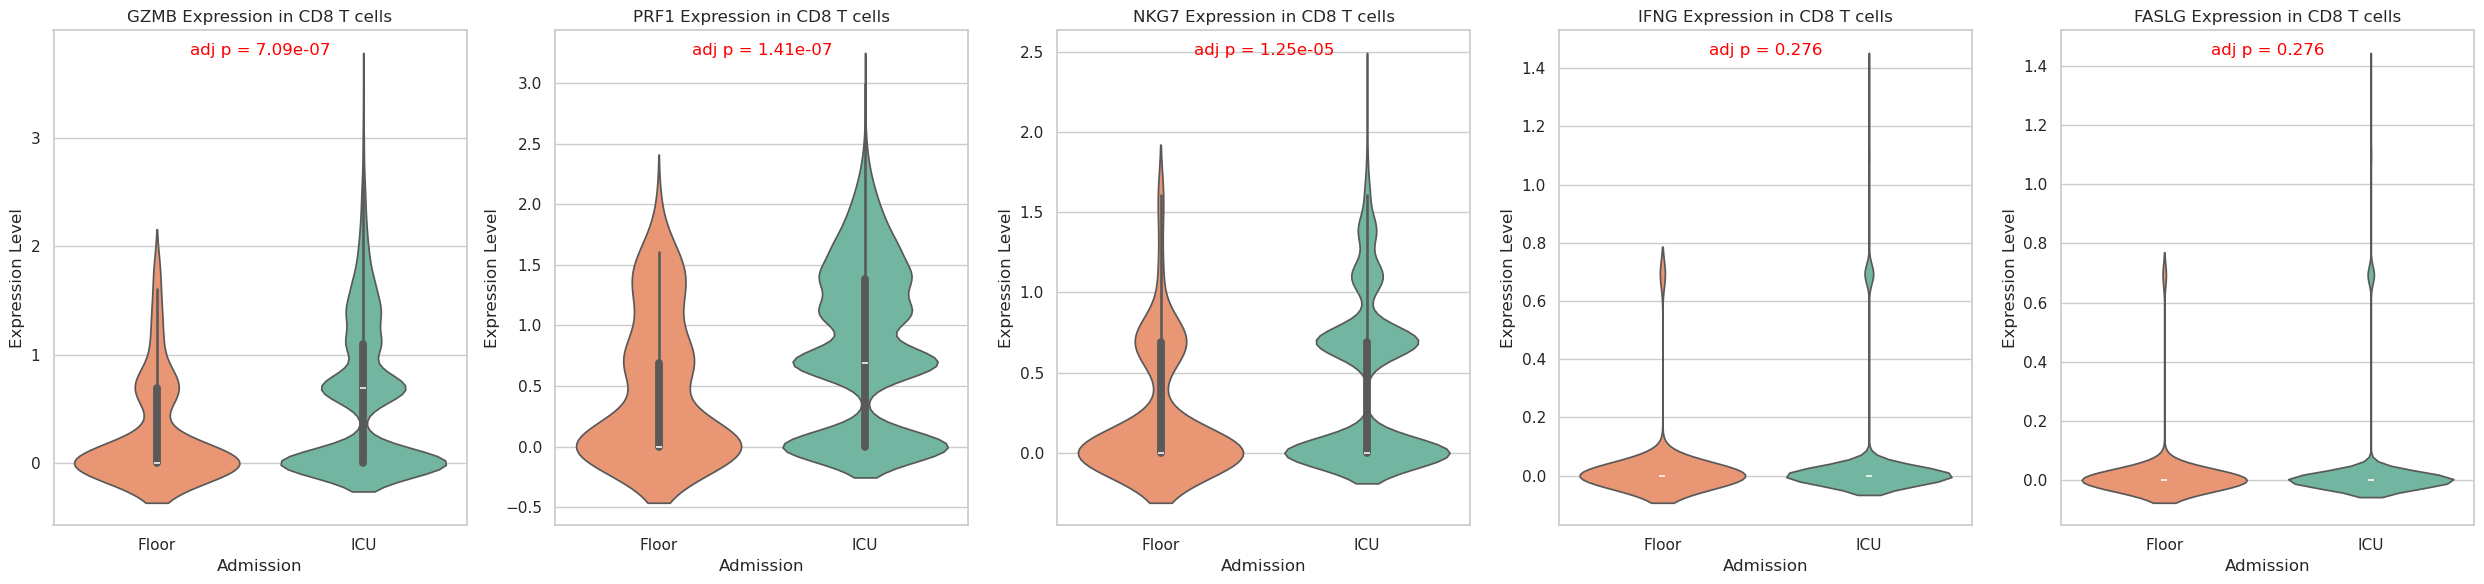

In [6]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

# NOTE: It is assumed that the adata object has already been normalized (e.g., log-normalized) prior to this analysis.

# Subset the adata object to obtain CD8 T cells based on 'cell_type_coarse'
cd8_mask = adata.obs['cell_type_coarse'] == 'CD8 T'
if cd8_mask.sum() == 0:
    raise ValueError('No CD8 T cells found based on "cell_type_coarse" annotation.')

cd8_cells = adata[cd8_mask].copy()

# Verify required clinical metadata ('Admission' and 'Status') are present
for col in ['Admission', 'Status']:
    if col not in cd8_cells.obs.columns:
        raise ValueError(f"Required clinical metadata '{col}' is missing in CD8 T cells data.")

# Focus on COVID patients to match analysis requirements
cd8_covid = cd8_cells[cd8_cells.obs['Status'] == 'COVID'].copy()

# Exclude ambiguous values in the 'Admission' field, retaining only ICU and Floor categories
cd8_covid = cd8_covid[cd8_covid.obs['Admission'].isin(['ICU', 'Floor'])].copy()

# Define the panel of key cytotoxic/activation genes
gene_panel = ['GZMB', 'PRF1', 'NKG7', 'IFNG', 'FASLG']

# Check that all required genes are present in the data
missing_genes = [gene for gene in gene_panel if gene not in cd8_covid.var_names]
if missing_genes:
    raise ValueError(f"The following genes are missing from the CD8 T cells dataset: {missing_genes}")

# Create a metadata DataFrame and add gene expression information
meta_cd8 = cd8_covid.obs.copy()
for gene in gene_panel:
    expr = cd8_covid[:, gene].X
    if hasattr(expr, 'toarray'):
        expr = expr.toarray().flatten()
    else:
        expr = np.array(expr).flatten()
    meta_cd8[gene] = expr

# Perform Mann-Whitney U tests to compare gene expression between ICU and Floor groups
de_results_cd8 = {}
for gene in gene_panel:
    icu_expr = meta_cd8.loc[meta_cd8['Admission'] == 'ICU', gene]
    floor_expr = meta_cd8.loc[meta_cd8['Admission'] == 'Floor', gene]
    if len(icu_expr) == 0 or len(floor_expr) == 0:
        raise ValueError(f"Insufficient data in one of the Admission groups for gene {gene} in CD8 T cells.")
    stat = mannwhitneyu(icu_expr, floor_expr, alternative='two-sided')
    de_results_cd8[gene] = {'U_statistic': stat.statistic, 'p_value': stat.pvalue}
    print(f"{gene} - ICU vs Floor in CD8 T cells: U = {stat.statistic:.2f}, p-value = {stat.pvalue:.4g}")

# Apply Benjamini-Hochberg correction for multiple testing
raw_pvals = [res['p_value'] for res in de_results_cd8.values()]

def benjamini_hochberg(pvals):
    pvals = np.array(pvals)
    m = len(pvals)
    order = np.argsort(pvals)
    ranked_pvals = pvals[order]
    bh_values = ranked_pvals * m / (np.arange(1, m+1))
    # Ensure monotonicity of adjusted p-values
    bh_adjusted = np.minimum.accumulate(bh_values[::-1])[::-1]
    adjusted_pvals = np.empty(m)
    adjusted_pvals[order] = bh_adjusted
    return adjusted_pvals

adjusted_pvals = benjamini_hochberg(raw_pvals)

# Incorporate adjusted p-values into the de_results_cd8 dictionary
for i, gene in enumerate(gene_panel):
    de_results_cd8[gene]['adjusted_p_value'] = adjusted_pvals[i]

# Save the DE test results in a structured DataFrame for reproducibility
de_results_cd8_df = pd.DataFrame(de_results_cd8).T.reset_index().rename(columns={'index': 'gene'})
print("\nDifferential expression results (Mann-Whitney U tests with BH correction):")
print(de_results_cd8_df)

# Visualization: Generate violin plots to compare gene expression by Admission group
sns.set(style='whitegrid')
fig, axes = plt.subplots(1, len(gene_panel), figsize=(5 * len(gene_panel), 6))
if len(gene_panel) == 1:
    axes = [axes]

for i, gene in enumerate(gene_panel):
    ax = axes[i]
    sns.violinplot(x='Admission', y=gene, data=meta_cd8, palette=['#fc8d62', '#66c2a5'], ax=ax)
    ax.set_title(f"{gene} Expression in CD8 T cells")
    p_adj = de_results_cd8[gene]['adjusted_p_value']
    ax.text(0.5, 0.95, f'adj p = {p_adj:.3g}', transform=ax.transAxes, horizontalalignment='center', fontsize=12, color='red')
    ax.set_ylabel('Expression Level')

plt.tight_layout()
plt.show()

### Agent Interpretation

The results show significant differential expression of GZMB, PRF1, and NKG7 in CD8 T cells between patients in the ICU and those on the floor, with adjusted p-values suggesting strong statistical significance. In contrast, IFNG and FASLG did not show significant differences.

**Feedback and Future Steps:**

1. **Promising Findings:**
   - The upregulation of GZMB, PRF1, and NKG7 in ICU patients suggests enhanced cytotoxic activity of CD8 T cells in severe cases. This finding aligns with the hypothesis of altered immune responses in severe COVID-19.

2. **Biological Interpretation:**
   - The increased expression of these cytotoxic genes could indicate a compensatory immune response or a marker of disease severity. Investigating whether these gene expressions correlate with clinical outcomes (e.g., recovery, mortality) might provide deeper insights.

3. **Further Iterations:**
   - **Pathway and Enrichment Analysis:** Conduct gene set enrichment analysis on the differentially expressed genes to identify pathways that might be upregulated or downregulated in ICU patients.
   - **Cell-Cell Communication Analysis:** Explore the downstream impact of these differentially expressed genes by analyzing potential interactions between monocytes and CD8 T cells. This could further elucidate communication pathways contributing to severe immune responses.
   - **Longitudinal Analysis:** If possible, perform a time-course study to observe how these expressions change with disease progression or treatment.

4. **Distinct Analyses:**
   - Given that the paper focused on depletion of NK cells and monocyte subtypes, continuing to explore CD8 T cell-specific responses contributes distinct insights into COVID-19 immunopathology.

By focusing on these promising gene expressions and incorporating additional analyses, the study can provide a comprehensive understanding of the immune mechanisms at play in severe COVID-19 cases.

## This code subsets the anndata object to isolate COVID-19 CD8 T cells and monocytes, filters for ICU and Floor admissions, and computes a pseudobulk average expression for selected inflammatory receptors and ligands on a per-donor basis, while handling potential sparse matrices. It then merges the two datasets (logging warnings if donors do not overlap) and performs Spearman correlation analyses, finally visualizing the ligand-receptor relationships using a robust grid of scatter plots with linear fits and statistical annotations.

In [ ]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

# Define cell types for subsetting
cd8_mask = (adata.obs['cell_type_coarse'] == 'CD8 T') & (adata.obs['Status'] == 'COVID')
mono_mask = ((adata.obs['cell_type_coarse'] == 'CD14 Monocyte') | (adata.obs['cell_type_coarse'] == 'CD16 Monocyte')) & (adata.obs['Status'] == 'COVID')

# Subset for CD8 T cells and monocytes
cd8_cells = adata[cd8_mask].copy()
monocytes = adata[mono_mask].copy()

# Ensure required clinical metadata are present for Admission and Donor
for col in ['Admission', 'Donor_full']:
    if col not in cd8_cells.obs.columns or col not in monocytes.obs.columns:
        raise ValueError(f"Required metadata '{col}' not found in one or both cell types.")

# Focus on non-ambiguous Admission categories
cd8_cells = cd8_cells[cd8_cells.obs['Admission'].isin(['ICU', 'Floor'])].copy()
monocytes = monocytes[monocytes.obs['Admission'].isin(['ICU', 'Floor'])].copy()

# Define receptor genes for CD8 T cells and ligand genes for monocytes
receptor_genes = ['TNFRSF1A', 'IL1R1', 'IL6R']
ligand_genes = ['TNF', 'IL1B', 'IL6']

# Check that all required genes are present in each dataset
for gene in receptor_genes:
    if gene not in cd8_cells.var_names:
        raise ValueError(f"Receptor gene '{gene}' not found in CD8 T cells dataset.")
for gene in ligand_genes:
    if gene not in monocytes.var_names:
        raise ValueError(f"Ligand gene '{gene}' not found in monocytes dataset.")

# Function to compute pseudobulk average gene expression per donor for a given AnnData object and gene list
def compute_pseudobulk(adata_obj, genes):
    # Create a DataFrame from metadata
    meta = adata_obj.obs.copy()
    # For each gene, extract expression, handling sparse matrices
    for gene in genes:
        expr = adata_obj[:, gene].X
        if hasattr(expr, 'toarray'):
            expr = expr.toarray().flatten()
        else:
            expr = np.array(expr).flatten()
        meta[gene] = expr
    # Group by Donor_full and Admission, computing mean expression
    bulk = meta.groupby(['Donor_full', 'Admission'])[genes].mean().reset_index()
    return bulk

# Compute pseudobulk for CD8 T cell receptors and monocyte ligands
cd8_bulk = compute_pseudobulk(cd8_cells, receptor_genes)
mono_bulk = compute_pseudobulk(monocytes, ligand_genes)

# Merge the pseudobulk data for each Admission group based on Donor_full and Admission
merged_data = pd.merge(cd8_bulk, mono_bulk, on=['Donor_full', 'Admission'], suffixes=('_receptor', '_ligand'))

# Check if any donors are missing in the merge and log a warning
if merged_data.empty:
    raise ValueError("No overlapping donors between CD8 T cells and monocytes. Check donor representation in both subsets.")
else:
    num_cd8 = cd8_bulk['Donor_full'].nunique()
    num_mono = mono_bulk['Donor_full'].nunique()
    num_merged = merged_data['Donor_full'].nunique()
    if num_merged < min(num_cd8, num_mono):
        print(f"Warning: Only {num_merged} donors overlap between CD8 T cells and monocytes out of {num_cd8} (CD8) and {num_mono} (monocytes).")

# Prepare a container for correlation results
corr_results = []

# For each Admission group (ICU and Floor), perform Spearman correlation for each ligand-receptor pair
for admission in merged_data['Admission'].unique():
    data_subset = merged_data[merged_data['Admission'] == admission]
    for rec in receptor_genes:
        for lig in ligand_genes:
            rec_col = f"{rec}_receptor"
            lig_col = f"{lig}_ligand"
            # Ensure there is variability and enough data points
            if data_subset.shape[0] < 3:
                continue
            coef, p_val = spearmanr(data_subset[lig_col], data_subset[rec_col])
            corr_results.append({
                'Admission': admission,
                'Receptor': rec,
                'Ligand': lig,
                'spearman_r': coef,
                'p_value': p_val
            })
            print(f"Admission: {admission}, {lig} vs {rec}: spearman r = {coef:.2f}, p = {p_val:.4g}")

# Visualization: Create a grid of scatter plots (rows: ligand genes, columns: receptor genes) for each Admission group
for admission in merged_data['Admission'].unique():
    data_subset = merged_data[merged_data['Admission'] == admission]
    fig, axes = plt.subplots(nrows=len(ligand_genes), ncols=len(receptor_genes), figsize=(5*len(receptor_genes), 4*len(ligand_genes)))
    # Ensure axes is always 2D for robust indexing
    axes = np.atleast_2d(axes)
    fig.suptitle(f'Cell-Cell Communication: Monocyte Ligands vs CD8 T cell Receptors ({admission})', fontsize=16)
    for i, lig in enumerate(ligand_genes):
        for j, rec in enumerate(receptor_genes):
            ax = axes[i, j]
            rec_col = f"{rec}_receptor"
            lig_col = f"{lig}_ligand"
            sns.scatterplot(x=lig_col, y=rec_col, data=data_subset, ax=ax, color='#66c2a5')
            # Fit and plot a linear trend line
            m, b = np.polyfit(data_subset[lig_col], data_subset[rec_col], 1)
            ax.plot(data_subset[lig_col], m*data_subset[lig_col] + b, color='red', linestyle='--')
            # Get correlation results for annotation
            curr_res = [res for res in corr_results if res['Admission'] == admission and res['Ligand'] == lig and res['Receptor'] == rec]
            if curr_res:
                r_val = curr_res[0]['spearman_r']
                p_val = curr_res[0]['p_value']
                ax.text(0.05, 0.90, f'r = {r_val:.2f}, p = {p_val:.3g}', transform=ax.transAxes, fontsize=12, color='blue')
            ax.set_xlabel(f"{lig} Expression (Monocytes)")
            ax.set_ylabel(f"{rec} Expression (CD8 T cells)")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()